# Library Imports

In [1]:
# Imports needed - Based on what I used for the other models
import torch.nn as nn
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import time
from threading import current_thread
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Import Data from the NPZ file

In [2]:
data = np.load('/content/drive/MyDrive/Dissertation Dataset/plant_disease_data.npz')
X = data['images']
y = data['labels']

# Unique Labels
unique_labels = np.unique(y)
num_classes = len(unique_labels)
print("Unique Labels:", unique_labels)
print("Number of Classes:", num_classes)

# Image and Label Shape
print("X Shape:", X.shape)
print("y Shape:", y.shape)

Unique Labels: [0 1 2 3 4]
Number of Classes: 5
X Shape: (20638, 256, 256, 3)
y Shape: (20638,)


# Assigning GPU Device

In [3]:
# Check the devices that I have
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data Splits and Seed

In [4]:
# Get the training and testing images ready:
# Define split ratios
train_ratio = 0.7  # 70% for training
val_ratio = 0.15  # 15% for validation
test_ratio = 0.15  # 15% for testing

# Step 1: Split into training and remaining data
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=(1 - train_ratio), random_state=42, stratify=y)

# Step 2: Split remaining data into validation and testing
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42, stratify=y_rem)

# Confirm split sizes
print("Training Set: ", X_train.shape, y_train.shape)
print("Validation Set: ", X_val.shape, y_val.shape)
print("Testing Set: ", X_test.shape, y_test.shape)

Training Set:  (14446, 256, 256, 3) (14446,)
Validation Set:  (3096, 256, 256, 3) (3096,)
Testing Set:  (3096, 256, 256, 3) (3096,)


# Tensor Conversions

In [5]:
X_val = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
y_val = torch.tensor(y_val, dtype=torch.long)

In [6]:
X_test = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test = torch.tensor(y_test, dtype=torch.long)

In [7]:
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [8]:
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
# Print all the images in Validation
print(X_val.shape)

torch.Size([3096, 3, 256, 256])


In [10]:
print(X_test.shape)

torch.Size([3096, 3, 256, 256])


# Initialising all the Models (Blanks)

In [11]:
# My CNN model implementation
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)

        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # Convolutional Layer 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Convolutional Layer 4
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)  # 2x2 Kernel and a Stride of 2. Reduces to (16, 128, 128)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)  # 2x2 Kernel and a Stride of 2. Reduces to (32, 64, 64)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten the tensor
        x = x.view(x.size(0), -1) # Flatten to (batch_size, 32 * 64 * 64)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [12]:
# import the models
from torchvision.models import resnet50, vgg16

vgg_model = vgg16(pretrained=True)
num_classes = 5
vgg_model.classifier[6] = nn.Linear(in_features=vgg_model.classifier[6].in_features, out_features=5)

resnet_model = resnet50(pretrained=True)
num_classes = 5
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

cnn10_model = CNN()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 226MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. 

# Importing the weights for all the models - The weights are the Training weights that we did previously

In [13]:
# Load saved weights
vgg_model.load_state_dict(torch.load('/content/drive/MyDrive/Dissertation Dataset/vgg_model_20epoch.pth'))
resnet_model.load_state_dict(torch.load('/content/drive/MyDrive/Dissertation Dataset/resnet50_20epoch.pth'))
cnn10_model.load_state_dict(torch.load('/content/drive/MyDrive/Dissertation Dataset/cnn_10layer_arc.pth'))

<All keys matched successfully>

In [14]:
# Predictions
resnet_predictions = torch.empty((0, num_classes)).to(device)
vgg_predictions = torch.empty((0, num_classes)).to(device)
cnn10_predictions = torch.empty((0, num_classes)).to(device)

resnet_predictions_test = torch.empty((0, num_classes)).to(device)
vgg_predictions_test = torch.empty((0, num_classes)).to(device)
cnn10_predictions_test = torch.empty((0, num_classes)).to(device)


In [15]:
# pass the images through the model
resnet_model.eval()
vgg_model.eval()
cnn10_model.eval()

resnet_model.to(device)
vgg_model.to(device)
cnn10_model.to(device)

resnet_allpreds = []
vgg_allpreds = []
cnn10_allpreds = []

with torch.no_grad():
  for images, labels in val_loader:
    images, labels = images.to(device), labels.to(device)

    resnet_output = resnet_model(images)
    vgg_output = vgg_model(images)
    cnn10_output = cnn10_model(images)

    probs_resnet = F.softmax(resnet_output, dim=1)
    probs_vgg = F.softmax(vgg_output, dim=1)
    probs_cnn10 = F.softmax(cnn10_output, dim=1)

    predictedLabel_resnet = torch.argmax(probs_resnet, dim=1)
    predictedLabel_vgg = torch.argmax(probs_vgg, dim=1)
    predictedLabel_cnn10 = torch.argmax(probs_cnn10, dim=1)

    # Store predictions and actual labels
    resnet_allpreds.extend(predictedLabel_resnet.cpu().numpy())
    vgg_allpreds.extend(predictedLabel_vgg.cpu().numpy())
    cnn10_allpreds.extend(predictedLabel_cnn10.cpu().numpy())

    resnet_predictions = torch.cat((resnet_predictions, probs_resnet), dim=0)
    vgg_predictions = torch.cat((vgg_predictions, probs_vgg), dim=0)
    cnn10_predictions = torch.cat((cnn10_predictions, probs_cnn10), dim=0)

  print(resnet_predictions.shape)
  print(vgg_predictions.shape)
  print(cnn10_predictions.shape)

  # print comparison
  for i in range(len(resnet_allpreds)):
    print(f"ResNet Prediction: {resnet_allpreds[i]}, VGG Prediction: {vgg_allpreds[i]}, CNN10 Prediction: {cnn10_allpreds[i]}, ACTUAL LABEL = {y_val[i]}")



torch.Size([3096, 5])
torch.Size([3096, 5])
torch.Size([3096, 5])
ResNet Prediction: 1, VGG Prediction: 1, CNN10 Prediction: 1, ACTUAL LABEL = 1
ResNet Prediction: 1, VGG Prediction: 1, CNN10 Prediction: 1, ACTUAL LABEL = 1
ResNet Prediction: 2, VGG Prediction: 2, CNN10 Prediction: 2, ACTUAL LABEL = 2
ResNet Prediction: 3, VGG Prediction: 3, CNN10 Prediction: 1, ACTUAL LABEL = 3
ResNet Prediction: 1, VGG Prediction: 1, CNN10 Prediction: 1, ACTUAL LABEL = 1
ResNet Prediction: 3, VGG Prediction: 3, CNN10 Prediction: 3, ACTUAL LABEL = 3
ResNet Prediction: 3, VGG Prediction: 3, CNN10 Prediction: 1, ACTUAL LABEL = 1
ResNet Prediction: 0, VGG Prediction: 0, CNN10 Prediction: 0, ACTUAL LABEL = 0
ResNet Prediction: 4, VGG Prediction: 4, CNN10 Prediction: 4, ACTUAL LABEL = 4
ResNet Prediction: 0, VGG Prediction: 0, CNN10 Prediction: 0, ACTUAL LABEL = 0
ResNet Prediction: 2, VGG Prediction: 2, CNN10 Prediction: 2, ACTUAL LABEL = 2
ResNet Prediction: 3, VGG Prediction: 3, CNN10 Prediction: 3, ACT

In [16]:
# Sanity Check
print(resnet_predictions[:5])
print(resnet_predictions[2])
temp = F.softmax(resnet_predictions[2], dim=0)
print(temp)
print(torch.argmax(temp, dim=0))

tensor([[1.9229e-15, 1.0000e+00, 1.4734e-16, 3.9752e-16, 1.9122e-12],
        [8.5063e-17, 1.0000e+00, 4.6321e-14, 2.6015e-10, 2.5941e-11],
        [3.0404e-04, 1.4451e-05, 9.9742e-01, 2.2612e-03, 1.8125e-08],
        [9.4130e-08, 7.2204e-09, 3.8129e-11, 1.0000e+00, 1.8137e-15],
        [3.0030e-08, 1.0000e+00, 4.3758e-10, 1.9876e-10, 2.6496e-08]],
       device='cuda:0')
tensor([3.0404e-04, 1.4451e-05, 9.9742e-01, 2.2612e-03, 1.8125e-08],
       device='cuda:0')
tensor([0.1490, 0.1489, 0.4038, 0.1493, 0.1489], device='cuda:0')
tensor(2, device='cuda:0')


In [17]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(resnet_allpreds, y_val)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9803


In [18]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(vgg_allpreds, y_val)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9461


In [19]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(cnn10_allpreds, y_val)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9696


# Hybrid Perceptron Training

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

# Ensure predictions and labels are on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume resnet_predictions, vgg_predictions, cnn10_predictions, and y_true are already on the correct device

# Define Perceptron
class Perceptron(nn.Module):
    def __init__(self, num_models=3, num_classes=5):
        super(Perceptron, self).__init__()

        # Initialize weights equally
        self.weights = nn.Parameter(torch.ones(num_models) / num_models)

        # Learnable gating parameters
        self.gates = nn.Parameter(torch.ones(num_models))

        # Softmax for final probability
        self.softmax = nn.Softmax(dim=1)

    def forward(self, vgg_predictions, resnet_predictions, cnn10_predictions):
        # Sigmoid to gates to keep values between 0 and 1
        gate_values = torch.sigmoid(self.gates)

        # Apply softmax to weights
        weight_values = torch.softmax(self.weights, dim=0)

        # Compute ensemble output
        ensemble_output = (
            gate_values[0] * weight_values[0] * vgg_predictions +
            gate_values[1] * weight_values[1] * resnet_predictions +
            gate_values[2] * weight_values[2] * cnn10_predictions
        )

        return self.softmax(ensemble_output), gate_values, weight_values

# Instantiate model
perceptron = Perceptron().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(perceptron.parameters(), lr=0.01)

# Number of training epochs
num_epochs = 100

y_val = y_val.to(device)

# gate value history
gate_value_history = []

# start time
start_time = time.time()

# Training Loop
for epoch in range(num_epochs):

    optimizer.zero_grad()

    # Forward pass
    outputs, gate_values, weight_values = perceptron(vgg_predictions, resnet_predictions, cnn10_predictions)

    # Compute loss
    loss = criterion(outputs, y_val)

    # Backpropagation
    loss.backward()

    # Update parameters
    optimizer.step()

    gate_value_history.append(gate_values.cpu().detach().numpy())
    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        print(f'Gate Values: {gate_values}')
        print(f'Weight Values: {weight_values}')

current_time = time.time()
elapsed_time = current_time - start_time
print(f"Elapsed time: {elapsed_time/60:.2f} minutes")



Epoch [10/100], Loss: 1.4745
Gate Values: tensor([0.7483, 0.7484, 0.7484], device='cuda:0', grad_fn=<SigmoidBackward0>)
Weight Values: tensor([0.2946, 0.3527, 0.3526], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Epoch [20/100], Loss: 1.4705
Gate Values: tensor([0.7660, 0.7668, 0.7668], device='cuda:0', grad_fn=<SigmoidBackward0>)
Weight Values: tensor([0.2551, 0.3728, 0.3721], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Epoch [30/100], Loss: 1.4666
Gate Values: tensor([0.7819, 0.7843, 0.7843], device='cuda:0', grad_fn=<SigmoidBackward0>)
Weight Values: tensor([0.2198, 0.3915, 0.3887], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Epoch [40/100], Loss: 1.4630
Gate Values: tensor([0.7956, 0.8008, 0.8007], device='cuda:0', grad_fn=<SigmoidBackward0>)
Weight Values: tensor([0.1886, 0.4091, 0.4023], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Epoch [50/100], Loss: 1.4596
Gate Values: tensor([0.8075, 0.8162, 0.8160], device='cuda:0', grad_fn=<SigmoidBackward0>)
Weight Values: tensor([0.161

In [21]:
print(gate_value_history)

[array([0.73105854, 0.73105854, 0.73105854], dtype=float32), array([0.7330202, 0.7330202, 0.7330202], dtype=float32), array([0.73497164, 0.7349727 , 0.7349727 ], dtype=float32), array([0.73691237, 0.7369163 , 0.7369163 ], dtype=float32), array([0.7388417, 0.738851 , 0.738851 ], dtype=float32), array([0.74075896, 0.74077684, 0.74077684], dtype=float32), array([0.74266356, 0.7426938 , 0.7426938 ], dtype=float32), array([0.7445549, 0.7446018, 0.7446018], dtype=float32), array([0.7464323, 0.746501 , 0.746501 ], dtype=float32), array([0.74829525, 0.7483914 , 0.7483913 ], dtype=float32), array([0.7501432 , 0.7502728 , 0.75027275], dtype=float32), array([0.75197554, 0.75214535, 0.75214523], dtype=float32), array([0.7537918 , 0.754009  , 0.75400877], dtype=float32), array([0.7555916 , 0.7558637 , 0.75586337], dtype=float32), array([0.75737435, 0.75770944, 0.75770897], dtype=float32), array([0.7591397 , 0.75954616, 0.7595455 ], dtype=float32), array([0.7608872, 0.7613738, 0.7613729], dtype=floa

# Gates and Weights Graphing

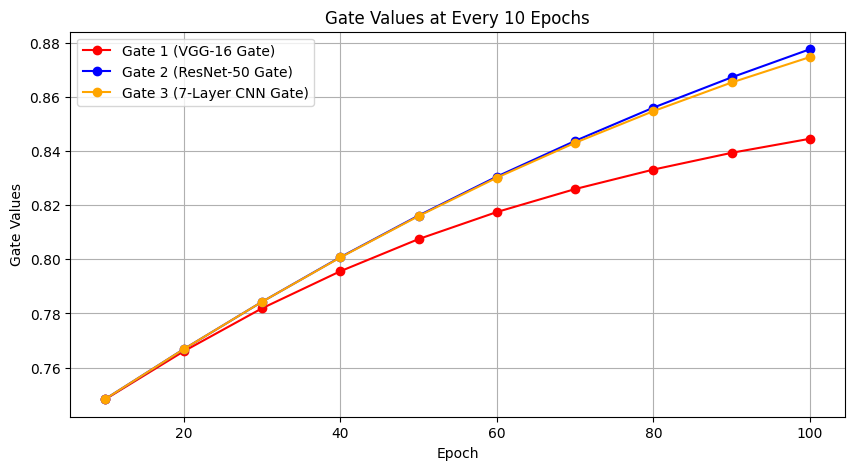

In [22]:
# Extracting data for every 10 epochs
epochs = np.arange(10, 101, 10)
gate_values_every_10 = np.array([
    [0.7483, 0.7484, 0.7484],
    [0.7660, 0.7668, 0.7668],
    [0.7819, 0.7843, 0.7843],
    [0.7956, 0.8008, 0.8007],
    [0.8075, 0.8162, 0.8160],
    [0.8175, 0.8306, 0.8302],
    [0.8260, 0.8438, 0.8431],
    [0.8332, 0.8561, 0.8548],
    [0.8394, 0.8673, 0.8654],
    [0.8446, 0.8777, 0.8748]
])

# Plot gate values at every 10 epochs
plt.figure(figsize=(10, 5))
for i in range(gate_values_every_10.shape[1]):
    #plt.plot(epochs, gate_values_every_10[:, i], marker='o', linestyle='-', label=f'Gate {i+1}')
    # change line colors
    if i == 0:
        plt.plot(
            epochs,
            gate_values_every_10[:, i],
            marker='o',
            linestyle='-',
            color='red',
            label=f'Gate {i+1} (VGG-16 Gate)'
        )
    if i == 1:
        plt.plot(
            epochs,
            gate_values_every_10[:, i],
            marker='o',
            linestyle='-',
            color='blue',
            label=f'Gate {i+1} (ResNet-50 Gate)'
        )
    if i == 2:
        plt.plot(
            epochs,
            gate_values_every_10[:, i],
            marker='o',
            linestyle='-',
            color='orange',
            label=f'Gate {i+1} (7-Layer CNN Gate)'
        )



plt.xlabel('Epoch')
plt.ylabel('Gate Values')
plt.title('Gate Values at Every 10 Epochs')
plt.legend()
plt.grid(True)
plt.show()

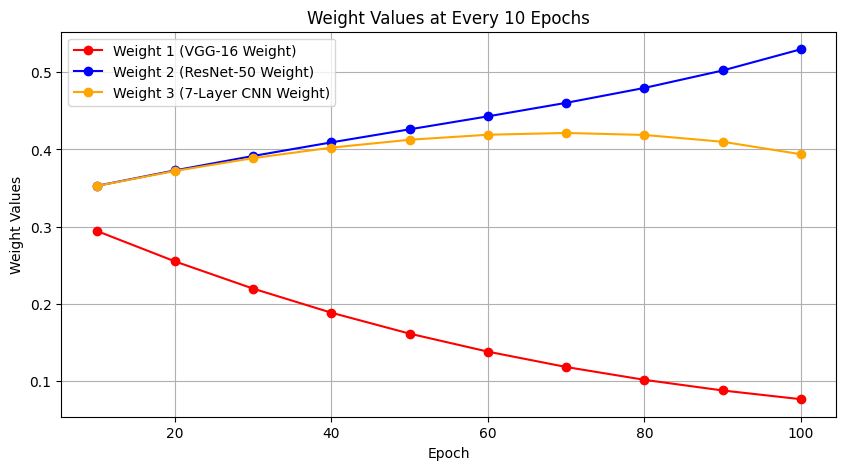

In [23]:
# Extracting weight values for every 10 epochs
weight_values_every_10 = np.array([
    [0.2946, 0.3527, 0.3526],
    [0.2551, 0.3728, 0.3721],
    [0.2198, 0.3915, 0.3887],
    [0.1886, 0.4091, 0.4023],
    [0.1615, 0.4260, 0.4125],
    [0.1382, 0.4428, 0.4190],
    [0.1183, 0.4603, 0.4213],
    [0.1017, 0.4796, 0.4187],
    [0.0879, 0.5022, 0.4099],
    [0.0766, 0.5297, 0.3937]
])

# Plot weight values at every 10 epochs
plt.figure(figsize=(10, 5))
for i in range(weight_values_every_10.shape[1]):
    if i==0:
        plt.plot(
            epochs,
            weight_values_every_10[:, i],
            marker='o',
            linestyle='-',
            color='red',
            label=f'Weight {i+1} (VGG-16 Weight)')
    if i==1:
        plt.plot(
            epochs,
            weight_values_every_10[:, i],
            marker='o',
            linestyle='-',
            color='blue',
            label=f'Weight {i+1} (ResNet-50 Weight)')
    if i == 2:
            plt.plot(
                epochs,
                weight_values_every_10[:, i],
                marker='o',
                linestyle='-',
                color='orange',
                label=f'Weight {i+1} (7-Layer CNN Weight)'
            )

plt.xlabel('Epoch')
plt.ylabel('Weight Values')
plt.title('Weight Values at Every 10 Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
# pass the images through the model
resnet_model.eval()
vgg_model.eval()
cnn10_model.eval()

resnet_model.to(device)
vgg_model.to(device)
cnn10_model.to(device)

resnet_allpreds = []
vgg_allpreds = []
cnn10_allpreds = []

with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    resnet_output = resnet_model(images)
    vgg_output = vgg_model(images)
    cnn10_output = cnn10_model(images)

    probs_resnet = F.softmax(resnet_output, dim=1)
    probs_vgg = F.softmax(vgg_output, dim=1)
    probs_cnn10 = F.softmax(cnn10_output, dim=1)

    predictedLabel_resnet = torch.argmax(probs_resnet, dim=1)
    predictedLabel_vgg = torch.argmax(probs_vgg, dim=1)
    predictedLabel_cnn10 = torch.argmax(probs_cnn10, dim=1)

    # Store predictions and actual labels
    resnet_allpreds.extend(predictedLabel_resnet.cpu().numpy())
    vgg_allpreds.extend(predictedLabel_vgg.cpu().numpy())
    cnn10_allpreds.extend(predictedLabel_cnn10.cpu().numpy())

    resnet_predictions_test = torch.cat((resnet_predictions_test, probs_resnet), dim=0)
    vgg_predictions_test = torch.cat((vgg_predictions_test, probs_vgg), dim=0)
    cnn10_predictions_test = torch.cat((cnn10_predictions_test, probs_cnn10), dim=0)

  print(resnet_predictions_test.shape)
  print(vgg_predictions_test.shape)
  print(cnn10_predictions_test.shape)

  # print comparison
  # for i in range(len(resnet_allpreds)):
  #   print(f"ResNet Prediction: {resnet_allpreds[i]}, VGG Prediction: {vgg_allpreds[i]}, CNN10 Prediction: {cnn10_allpreds[i]}, ACTUAL LABEL = {y_test[i]}")



torch.Size([3096, 5])
torch.Size([3096, 5])
torch.Size([3096, 5])


# Evaluating Perceptron

In [26]:
# Set model to evaluation mode
perceptron.eval()

# Disable gradient computation for inference
with torch.no_grad():
    # Forward pass through the perceptron
    ensemble_outputs, gate_values, weight_values = perceptron(vgg_predictions_test, resnet_predictions_test, cnn10_predictions_test)
    print(ensemble_outputs.shape)
    # Get predicted class (highest probability)
    predicted_classes_test = torch.argmax(ensemble_outputs, dim=1)

# Print some predictions
print("Predicted classes:", predicted_classes_test[:10].cpu().numpy())  # Print first 10 predictions
print("Actual labels:", y_test[:10].cpu().numpy())  # Print first 10 actual labels
# size of predicted classes
print(predicted_classes_test.shape)

torch.Size([3096, 5])
Predicted classes: [1 1 2 0 3 3 3 3 1 2]
Actual labels: [1 1 2 0 3 3 3 3 1 2]
torch.Size([3096])


In [27]:
# Compute accuracy
print(predicted_classes_test.shape)
print(y_test.shape)
y_test = y_test.to(device)
predicted_classes_test = predicted_classes_test.to(device)
correct = (predicted_classes_test == y_test).sum().item()
total = y_test.size(0)
accuracy = correct / total

print(f"Ensemble Accuracy: {accuracy * 100:.2f}%")

torch.Size([3096])
torch.Size([3096])
Ensemble Accuracy: 98.71%


In [28]:
# f1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test.cpu().numpy(), predicted_classes_test.cpu().numpy(), average='macro')
print(f"F1 Score: {f1 * 100:.2f}%")

F1 Score: 98.40%


In [29]:
# precision and recall
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test.cpu().numpy(), predicted_classes_test.cpu().numpy(), average='macro')
recall = recall_score(y_test.cpu().numpy(), predicted_classes_test.cpu().numpy(), average='macro')
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")

Precision: 98.54%
Recall: 98.28%


In [30]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = confusion_matrix(y_test.cpu().numpy(), predicted_classes_test.cpu().numpy())
print(confusion_matrix)


[[ 482    0    0    1    0]
 [   3 1341    0    8    3]
 [   0    4  532    1    1]
 [   1    4    2  461    0]
 [   6    5    1    0  240]]


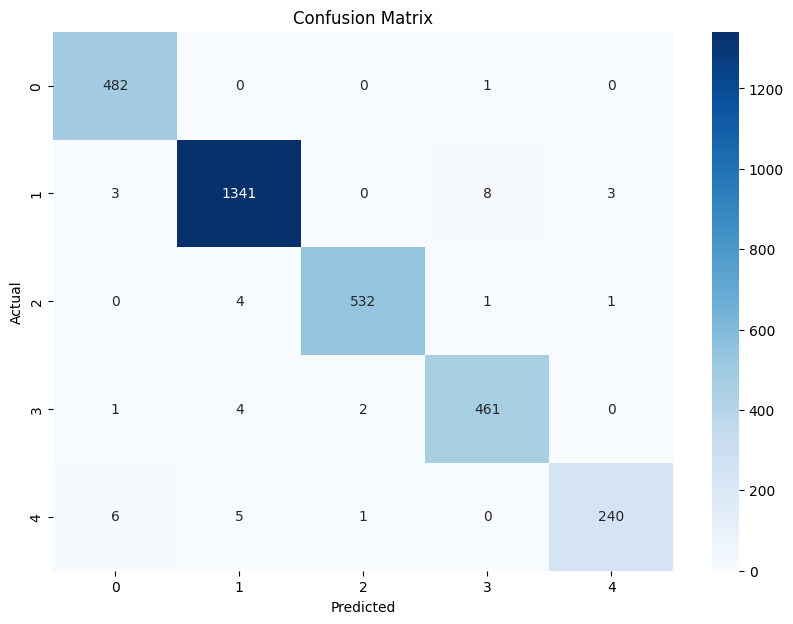

In [31]:
# plot confusion matrix on a heat map
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [32]:
print("Learned Weight Values:", weight_values.cpu().numpy())
print("Learned Gate Values:", gate_values.cpu().numpy())

Learned Weight Values: [0.07559797 0.5328526  0.3915494 ]
Learned Gate Values: [0.8451001  0.8787411  0.87563044]
